In [1]:
import pandas as pd
import numpy as np
import keras
import sys
import h5py
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, matthews_corrcoef




Mounted at /content/drive


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
CleanDataFile = "/content/drive/MyDrive/MLcybersecHW4/cl1/cl/valid.h5"
PoisonDataFile = "/content/drive/MyDrive/MLcybersecHW4/bd1/bd/bd_valid.h5"
ModelFile = "/content/drive/MyDrive/MLcybersecHW4/bd_net.h5"

def Dataloader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [4]:
# Loading the dataset
images, labels = Dataloader(CleanDataFile)


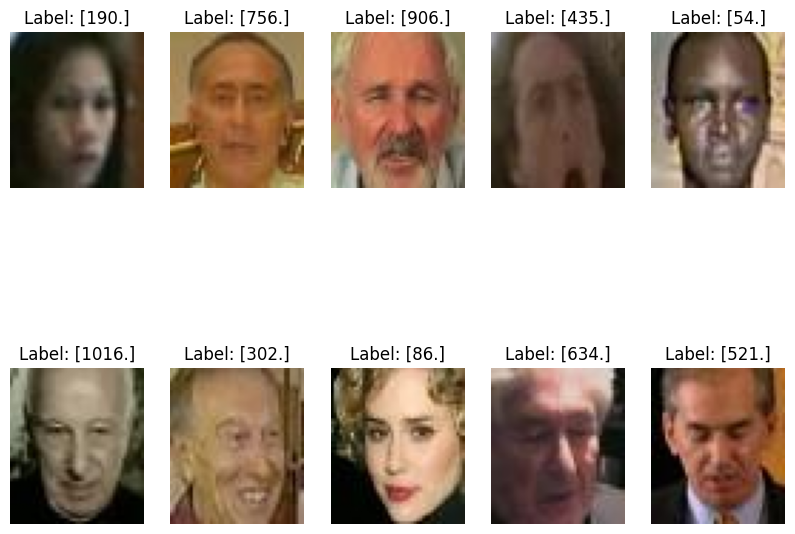

In [5]:
# Create a figure for plotting
plot_figure = plt.figure(figsize=(10, 8))
num_columns, num_rows = 5, 2

# Displaying a selection of images and their corresponding labels
for plot_position in range(1, num_columns * num_rows + 1):
    random_idx = np.random.randint(images.shape[0], size=1)
    selected_image, corresponding_label = (images[random_idx], labels[random_idx])

    # Add a subplot for each image
    plot_figure.add_subplot(num_rows, num_columns, plot_position)
    plt.title(f"Label: {corresponding_label}")
    plt.axis('off')
    plt.imshow(selected_image[0] / 255)  # Normalize the image data

# Save and display the figure
plt.savefig("VisualizedCleanedData.png")
plt.show()

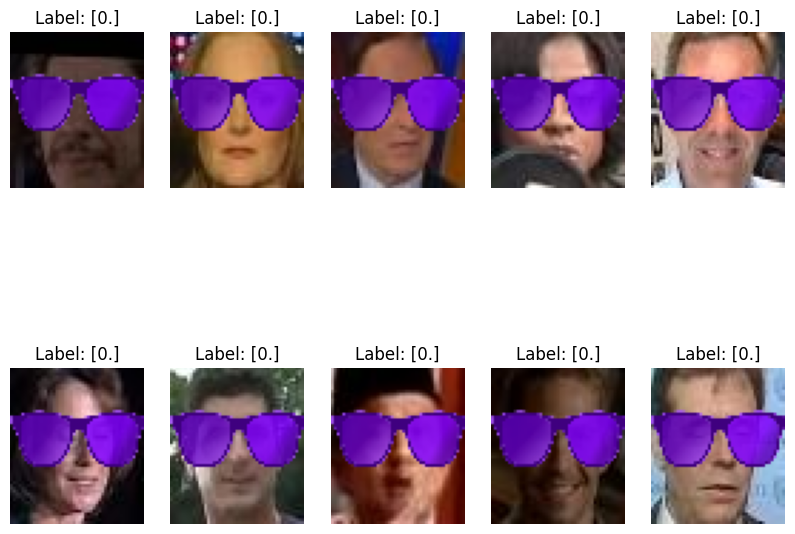

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Load poisoned data using the custom data loader
poisoned_images, poisoned_labels = Dataloader(PoisonDataFile)

# Initialize the plot with specified dimensions
visualization_figure = plt.figure(figsize=(10, 8))
number_of_columns, number_of_rows = 5,2

# Loop for plotting selected images with labels
for position in range(1, number_of_columns * number_of_rows + 1):
    chosen_index = np.random.randint(poisoned_images.shape[0], size=1)
    chosen_image, chosen_label = (poisoned_images[chosen_index], poisoned_labels[chosen_index])

    # Add each image as a subplot to the main figure
    visualization_figure.add_subplot(number_of_rows, number_of_columns, position)
    plt.title(f"Label: {chosen_label}")
    plt.axis('off')
    plt.imshow(chosen_image[0] / 255)  # Normalizing the image for display

# Saving the figure and showing the plot
plt.savefig("VisualizedPoisonedData.png")
plt.show()

In [7]:
Model = keras.models.load_model(ModelFile)
print(Model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [8]:
Clean_X_Test, Clean_Y_Test = Dataloader(CleanDataFile)
BadNet_X_Test, BadNet_Y_Test = Dataloader(PoisonDataFile)
BadNet_Model = keras.models.load_model(ModelFile)

print("================================================================================================================")
print("\n\nStatistics on Clean Dataset\n\n")
Clean_Prediction = np.argmax(BadNet_Model.predict(Clean_X_Test), axis=1)
Clean_Accuracy = np.mean(np.equal(Clean_Prediction, Clean_Y_Test)) * 100
print('Classification Accuracy on Clean Data:', Clean_Accuracy)

# Additional Statistics for Clean Data
cm_clean = confusion_matrix(Clean_Y_Test, Clean_Prediction)
precision_clean, recall_clean, f1_score_clean, _ = precision_recall_fscore_support(Clean_Y_Test, Clean_Prediction, average='weighted')
print("Confusion Matrix for Clean Data:\n", cm_clean)
print(f"Precision for Clean Data: {precision_clean:.2f}")
print(f"Recall for Clean Data: {recall_clean:.2f}")
print(f"F1 Score for Clean Data: {f1_score_clean:.2f}")
print("================================================================================================================")

print("\n\n================================================================================================================")
print("\n\nStatistics on Poisoned Dataset\n\n")
BadNet_Prediction = np.argmax(BadNet_Model.predict(BadNet_X_Test), axis=1)
BadNet_AttackSuccesRate = np.mean(np.equal(BadNet_Prediction, BadNet_Y_Test)) * 100
print('Attack Success Rate:', BadNet_AttackSuccesRate)

# Additional Statistics for BadNet Data
cm_badnet = confusion_matrix(BadNet_Y_Test, BadNet_Prediction)
precision_badnet, recall_badnet, f1_score_badnet, _ = precision_recall_fscore_support(BadNet_Y_Test, BadNet_Prediction, average='weighted')
print("Confusion Matrix for BadNet Data:\n", cm_badnet)
print(f"Precision for BadNet Data: {precision_badnet:.2f}")
print(f"Recall for BadNet Data: {recall_badnet:.2f}")
print(f"F1 Score for BadNet Data: {f1_score_badnet:.2f}")
print("================================================================================================================")



Statistics on Clean Dataset


361/361 [==============================] - 9s 4ms/step
Classification Accuracy on Clean Data: 98.64899974019225
Confusion Matrix for Clean Data:
 [[8 0 0 ... 0 0 0]
 [0 9 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 9 0 0]
 [0 0 0 ... 0 9 0]
 [0 0 0 ... 0 0 9]]
Precision for Clean Data: 0.99
Recall for Clean Data: 0.99
F1 Score for Clean Data: 0.99




Statistics on Poisoned Dataset


361/361 [==============================] - 1s 2ms/step
Attack Success Rate: 100.0
Confusion Matrix for BadNet Data:
 [[11547]]
Precision for BadNet Data: 1.00
Recall for BadNet Data: 1.00
F1 Score for BadNet Data: 1.00


In [9]:
keras.backend.clear_session()


In [10]:
def predict_in_batches(model, data, batch_size=32):
    return np.concatenate([model.predict_on_batch(data[i:i + batch_size]) for i in range(0, len(data), batch_size)])

# Load test datasets
Clean_X_Test, Clean_Y_Test = Dataloader(CleanDataFile)
BadNet_X_Test, BadNet_Y_Test = Dataloader(PoisonDataFile)

# Copy the original model
model_copy = keras.models.clone_model(Model)
model_copy.set_weights(Model.get_weights())

# Initialize variables for tracking and statistics
saved_model = np.zeros(3, dtype=bool)
clean_data_acc = 100
prune_index = []
clean_acc = []
asrate = []

# Extract layer outputs and prepare for pruning
layer_output = model_copy.get_layer('pool_3').output
interm_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
interm_prediction = predict_in_batches(interm_model, Clean_X_Test)
temp = np.mean(interm_prediction, axis=(0, 1, 2))
seq = np.argsort(temp)

# Get weights and biases from the layer to be pruned
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

# Start pruning channels
for channel_index in tqdm(seq):
    weight_0[:, :, :, channel_index] = 0
    bias_0[channel_index] = 0
    model_copy.layers[5].set_weights([weight_0, bias_0])

    # Predict and evaluate in batches
    cl_label_pred = np.argmax(predict_in_batches(model_copy, Clean_X_Test), axis=1)
    bd_label_pred = np.argmax(predict_in_batches(model_copy, BadNet_X_Test), axis=1)

    cl_accuracy = np.mean(np.equal(cl_label_pred, Clean_Y_Test)) * 100
    asr = np.mean(np.equal(bd_label_pred, BadNet_Y_Test)) * 100
    clean_acc.append(cl_accuracy)
    asrate.append(asr)

    # Save model at certain accuracy drop thresholds
    if (clean_data_acc - cl_accuracy >= 2 and not saved_model[0]):
        model_copy.save('PrunedModel_2.h5')
        saved_model[0] = True
    if (clean_data_acc - cl_accuracy >= 4 and not saved_model[1]):
        model_copy.save('PrunedModel_4.h5')
        saved_model[1] = True
    if (clean_data_acc - cl_accuracy >= 10 and not saved_model[2]):
        model_copy.save('PrunedModel_10.h5')
        saved_model[2] = True

     # Print statistics occasionally to reduce memory usage
    if channel_index % 1 == 0:
        cm_clean = confusion_matrix(Clean_Y_Test, cl_label_pred)
        precision_clean, recall_clean, f1_score_clean, _ = precision_recall_fscore_support(Clean_Y_Test, cl_label_pred, average='weighted')
        cm_poisoned = confusion_matrix(BadNet_Y_Test, bd_label_pred)
        precision_poisoned, recall_poisoned, f1_score_poisoned, _ = precision_recall_fscore_support(BadNet_Y_Test, bd_label_pred, average='weighted')
        print("\nClean Classification Accuracy: ", cl_accuracy)
        print("Attack Success Rate: ", asr)
        print("Pruned Channel Index: ", channel_index)
        print("Precision, Recall, F1 Score for Clean Data: ", precision_clean, recall_clean, f1_score_clean)
        print("Precision, Recall, F1 Score for Poisoned Data: ", precision_poisoned, recall_poisoned, f1_score_poisoned)

    # Clear session and temporary variables
    del cl_label_pred, bd_label_pred
    if 'cm_clean' in locals():
        del cm_clean
    if 'cm_poisoned' in locals():
        del cm_poisoned
    keras.backend.clear_session()

  2%|▏         | 1/60 [00:06<06:37,  6.74s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  0
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


  3%|▎         | 2/60 [00:11<05:36,  5.79s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  26
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


  5%|▌         | 3/60 [00:17<05:26,  5.73s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  27
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


  7%|▋         | 4/60 [00:24<05:45,  6.17s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  30
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


  8%|▊         | 5/60 [00:29<05:20,  5.84s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  31
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 10%|█         | 6/60 [00:38<06:17,  7.00s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  33
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 12%|█▏        | 7/60 [00:44<05:40,  6.43s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  34
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 13%|█▎        | 8/60 [00:49<05:17,  6.11s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  36
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 15%|█▌        | 9/60 [00:56<05:24,  6.37s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  37
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 17%|█▋        | 10/60 [01:01<04:58,  5.97s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  38
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 18%|█▊        | 11/60 [01:07<04:54,  6.01s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  25
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 20%|██        | 12/60 [01:13<04:46,  5.97s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  39
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 22%|██▏       | 13/60 [01:18<04:27,  5.70s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  41
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 23%|██▎       | 14/60 [01:25<04:40,  6.09s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  44
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 25%|██▌       | 15/60 [01:30<04:21,  5.81s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  45
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 27%|██▋       | 16/60 [01:36<04:08,  5.65s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  47
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 28%|██▊       | 17/60 [01:42<04:15,  5.95s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  48
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 30%|███       | 18/60 [01:47<03:58,  5.69s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  49
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 32%|███▏      | 19/60 [01:54<04:09,  6.07s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  50
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 33%|███▎      | 20/60 [02:00<03:58,  5.96s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  53
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 35%|███▌      | 21/60 [02:05<03:43,  5.72s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  55
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 37%|███▋      | 22/60 [02:12<03:51,  6.09s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  40
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 38%|███▊      | 23/60 [02:17<03:33,  5.77s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  24
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 40%|████      | 24/60 [02:22<03:23,  5.66s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  59
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 42%|████▏     | 25/60 [02:29<03:27,  5.91s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  9
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 43%|████▎     | 26/60 [02:34<03:13,  5.69s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  2
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 45%|████▌     | 27/60 [02:41<03:22,  6.13s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  12
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 47%|████▋     | 28/60 [02:49<03:26,  6.47s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  13
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 48%|████▊     | 29/60 [02:54<03:07,  6.06s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  17
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 50%|█████     | 30/60 [03:01<03:08,  6.30s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  14
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 52%|█████▏    | 31/60 [03:06<02:53,  5.97s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  15
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 53%|█████▎    | 32/60 [03:11<02:45,  5.91s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  23
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 55%|█████▌    | 33/60 [03:18<02:44,  6.08s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  6
Precision, Recall, F1 Score for Clean Data:  0.9877218909954686 0.9864899974019226 0.9864213454180131
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 57%|█████▋    | 34/60 [03:23<02:32,  5.86s/it]


Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  51
Precision, Recall, F1 Score for Clean Data:  0.9876297773413908 0.9864033948211657 0.9863303724903014
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 58%|█████▊    | 35/60 [03:30<02:32,  6.11s/it]


Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  32
Precision, Recall, F1 Score for Clean Data:  0.9876297773413908 0.9864033948211657 0.9863303724903014
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 60%|██████    | 36/60 [03:35<02:20,  5.85s/it]


Clean Classification Accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned Channel Index:  22
Precision, Recall, F1 Score for Clean Data:  0.9875386759252698 0.9863167922404088 0.9862500170926146
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 62%|██████▏   | 37/60 [03:40<02:09,  5.63s/it]


Clean Classification Accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned Channel Index:  21
Precision, Recall, F1 Score for Clean Data:  0.987758331561917 0.9865765999826794 0.986506526965711
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 63%|██████▎   | 38/60 [03:47<02:11,  5.97s/it]


Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  20
Precision, Recall, F1 Score for Clean Data:  0.9877140461513025 0.9864899974019226 0.9864285846430298
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 65%|██████▌   | 39/60 [03:52<02:00,  5.73s/it]


Clean Classification Accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned Channel Index:  19
Precision, Recall, F1 Score for Clean Data:  0.9873231535936133 0.9860569844981381 0.9859993359447401
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 67%|██████▋   | 40/60 [03:58<01:55,  5.76s/it]


Clean Classification Accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned Channel Index:  43
Precision, Recall, F1 Score for Clean Data:  0.986671770198431 0.9857105741751104 0.9854492548726385
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 68%|██████▊   | 41/60 [04:04<01:51,  5.87s/it]


Clean Classification Accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned Channel Index:  58
Precision, Recall, F1 Score for Clean Data:  0.9863438613358378 0.9853641638520828 0.9850881544767295
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 70%|███████   | 42/60 [04:09<01:41,  5.63s/it]


Clean Classification Accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned Channel Index:  3
Precision, Recall, F1 Score for Clean Data:  0.9833873392055043 0.9819000606218066 0.9815817630645494
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 72%|███████▏  | 43/60 [04:16<01:40,  5.92s/it]


Clean Classification Accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned Channel Index:  42
Precision, Recall, F1 Score for Clean Data:  0.979256361496974 0.9765307006148783 0.9756376752863315
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


 73%|███████▎  | 44/60 [04:21<01:31,  5.75s/it]


Clean Classification Accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned Channel Index:  1
Precision, Recall, F1 Score for Clean Data:  0.977903752038363 0.9750584567420109 0.9741636171608734
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 75%|███████▌  | 45/60 [04:26<01:23,  5.57s/it]


Clean Classification Accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned Channel Index:  29
Precision, Recall, F1 Score for Clean Data:  0.96360513462154 0.9575647354291158 0.9555788752407384
Precision, Recall, F1 Score for Poisoned Data:  1.0 1.0 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 77%|███████▋  | 46/60 [04:33<01:23,  5.94s/it]


Clean Classification Accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  16
Precision, Recall, F1 Score for Clean Data:  0.9593722633410177 0.9520221702606738 0.9501152900831059
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.9999133974192431 0.9999566968345385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 78%|███████▊  | 47/60 [04:38<01:13,  5.69s/it]


Clean Classification Accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  56
Precision, Recall, F1 Score for Clean Data:  0.956091900002656 0.947172425738287 0.9452207235916367
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.9999133974192431 0.9999566968345385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 80%|████████  | 48/60 [04:44<01:08,  5.68s/it]


Clean Classification Accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  46
Precision, Recall, F1 Score for Clean Data:  0.9361294294755621 0.9209318437689443 0.9182803742334351
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.9999133974192431 0.9999566968345385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 82%|████████▏ | 49/60 [04:50<01:04,  5.86s/it]


Clean Classification Accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  5
Precision, Recall, F1 Score for Clean Data:  0.9301595758925669 0.9149562656967177 0.9121412701829643
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.9999133974192431 0.9999566968345385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 83%|████████▎ | 50/60 [04:55<00:56,  5.66s/it]


Clean Classification Accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned Channel Index:  8
Precision, Recall, F1 Score for Clean Data:  0.927637905449787 0.9101931237550879 0.9075431012831217
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.9998267948384861 0.9999133899185865


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 85%|████████▌ | 51/60 [05:02<00:53,  5.98s/it]


Clean Classification Accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned Channel Index:  11
Precision, Recall, F1 Score for Clean Data:  0.914834471469071 0.8917467740538668 0.8888279552117956
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.8073958603966398 0.8934355534259703


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 87%|████████▋ | 52/60 [05:08<00:46,  5.84s/it]


Clean Classification Accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned Channel Index:  54
Precision, Recall, F1 Score for Clean Data:  0.8827602061275254 0.8443751623798389 0.8421506759781178
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.77015675067117 0.870156555772994


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 88%|████████▊ | 53/60 [05:13<00:39,  5.59s/it]


Clean Classification Accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned Channel Index:  10
Precision, Recall, F1 Score for Clean Data:  0.8266492803917812 0.7648739932449987 0.7604847437174644
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.35714904304148265 0.5263225065407441


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|█████████ | 54/60 [05:20<00:35,  5.96s/it]


Clean Classification Accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned Channel Index:  28
Precision, Recall, F1 Score for Clean Data:  0.650776320346695 0.548627349095003 0.5349285297201062
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.06954187234779596 0.13004048582995953


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 92%|█████████▏| 55/60 [05:25<00:28,  5.71s/it]


Clean Classification Accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned Channel Index:  35
Precision, Recall, F1 Score for Clean Data:  0.34388741225341374 0.2708928726076037 0.24413337869577903
Precision, Recall, F1 Score for Poisoned Data:  1.0 0.004243526457088421 0.008451190065539842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 93%|█████████▎| 56/60 [05:30<00:22,  5.73s/it]


Clean Classification Accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned Channel Index:  18
Precision, Recall, F1 Score for Clean Data:  0.16147220960880865 0.1387373343725643 0.11029968623758497
Precision, Recall, F1 Score for Poisoned Data:  0.0 0.0 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 95%|█████████▌| 57/60 [05:37<00:17,  5.88s/it]


Clean Classification Accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned Channel Index:  4
Precision, Recall, F1 Score for Clean Data:  0.07380632432702064 0.07101411622066338 0.05090476340533839
Precision, Recall, F1 Score for Poisoned Data:  0.0 0.0 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 97%|█████████▋| 58/60 [05:42<00:11,  5.64s/it]


Clean Classification Accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned Channel Index:  7
Precision, Recall, F1 Score for Clean Data:  0.008104252046591737 0.015501861955486274 0.00697149000426066
Precision, Recall, F1 Score for Poisoned Data:  0.0 0.0 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 98%|█████████▊| 59/60 [05:48<00:05,  5.88s/it]


Clean Classification Accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned Channel Index:  52
Precision, Recall, F1 Score for Clean Data:  0.001892084703785728 0.007188014202823244 0.0018063666320363805
Precision, Recall, F1 Score for Poisoned Data:  0.0 0.0 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 60/60 [05:54<00:00,  5.90s/it]


Clean Classification Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  57
Precision, Recall, F1 Score for Clean Data:  6.075005664942783e-07 0.000779423226812159 1.2140548704239238e-06
Precision, Recall, F1 Score for Poisoned Data:  0.0 0.0 0.0


In [11]:
print(f"{'Clean Data Accuracy (%)':<30} {'Attack Success Rate (%)':<30}")
print("-" * 60)

for clean_accuracy, attack_rate in zip(clean_acc, asrate):
    print(f"{clean_accuracy:<30} {attack_rate:<30}")

Clean Data Accuracy (%)        Attack Success Rate (%)       
------------------------------------------------------------
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.64899974019225              100.0                         
98.648999

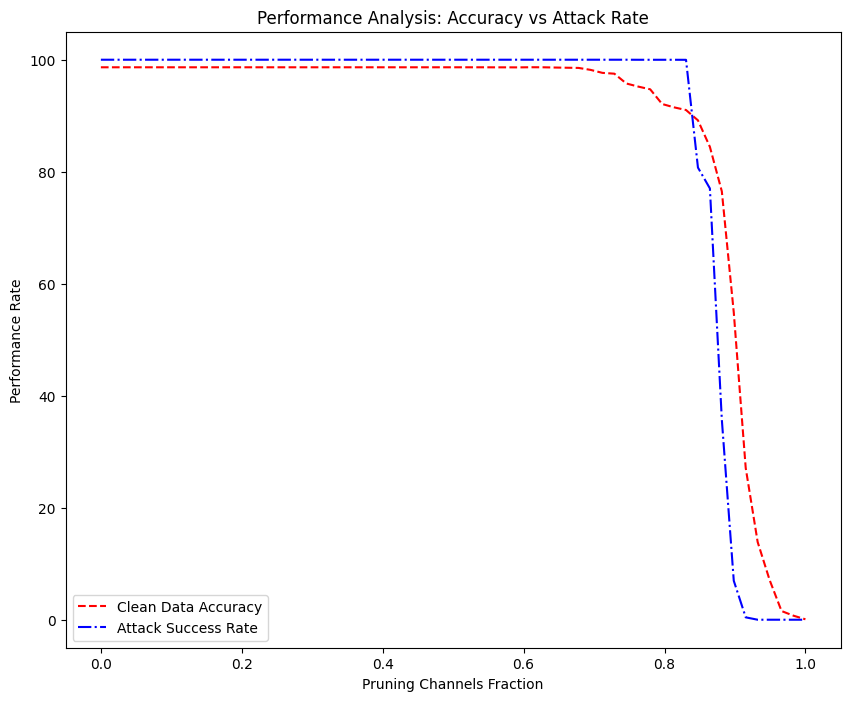

In [12]:
# Initialize the plot
accuracy_figure = plt.figure(figsize=(10, 8))

# Generate x-axis values representing the fraction of pruned channels
pruning_fraction = np.linspace(0, 1, num=60)

# Plotting clean data accuracy and attack success rate
plt.plot(pruning_fraction, clean_acc, 'r--', label='Clean Data Accuracy')
plt.plot(pruning_fraction, asrate, 'b-.', label='Attack Success Rate')

# Adding plot legend, labels, and title
plt.legend()
plt.xlabel("Pruning Channels Fraction")
plt.ylabel("Performance Rate")
plt.title("Performance Analysis: Accuracy vs Attack Rate")

# Saving the figure
plt.savefig("PerformanceAnalysisPlot.png")
plt.show()

In [13]:
# Finding the index where clean data accuracy drops by at least 30% from the initial accuracy
threshold_drop = 30
accuracy_threshold = clean_data_acc - threshold_drop
threshold_index = np.where(np.array(clean_acc) <= accuracy_threshold)[0]

if threshold_index.size > 0:
    first_threshold_index = threshold_index[0]
    attack_rate_at_threshold = asrate[first_threshold_index]
    print(f"Attack Success Rate at 30% Accuracy Drop: {attack_rate_at_threshold}")
else:
    print("No drop in accuracy by 30% observed.")

Attack Success Rate at 30% Accuracy Drop: 6.954187234779596


In [14]:
class CustomPredictor(keras.Model):
    def __init__(self, primary_model, secondary_model):
        """
        Initialize the custom predictor with two models.# Ensuring there is at least one index meeting the condition

        :param primary_model: The primary prediction model.
        :param secondary_model: The secondary prediction model used for verification.
        """
        super(CustomPredictor, self).__init__()
        self.primary_model = primary_model
        self.secondary_model = secondary_model

    def predict(self, input_data):
        """
        Make predictions based on the agreement between the primary and secondary models.
        If both models agree on the prediction, that prediction is returned.
        Otherwise, a default value is assigned.

        :param input_data: The input data for prediction.
        :return: Array of predictions.
        """
        primary_predictions = np.argmax(self.primary_model(input_data), axis=1)
        secondary_predictions = np.argmax(self.secondary_model(input_data), axis=1)

        predictions = np.zeros(input_data.shape[0])
        for i in range(input_data.shape[0]):
            if primary_predictions[i] == secondary_predictions[i]:
                predictions[i] = primary_predictions[i]
            else:
                predictions[i] = 1283  # Default value when predictions do not match

        return predictions

In [16]:
# Paths for test datasets and pruned models
clean_test_path = '/content/drive/MyDrive/MLcybersecHW4/cl1/cl/test.h5'
poisoned_test_path = '/content/drive/MyDrive/MLcybersecHW4/bd1/bd/bd_test.h5'
model_path_2_percent_prune = 'PrunedModel_2.h5'
model_path_4_percent_prune = 'PrunedModel_4.h5'
model_path_10_percent_prune = 'PrunedModel_10.h5'

# Loading test data sets using the custom Dataloader function
test_images, test_labels = Dataloader(clean_test_path)
poisoned_test_images, poisoned_test_labels = Dataloader(poisoned_test_path)

# Displaying the shapes of the loaded test data sets
print(f"Dimensions of Test Images: {test_images.shape}")
print(f"Dimensions of Poisoned Test Images: {poisoned_test_images.shape}")

# Loading the pruned models at different pruning levels
model_with_2_percent_pruning = keras.models.load_model(model_path_2_percent_prune)
model_with_4_percent_pruning = keras.models.load_model(model_path_4_percent_prune)
model_with_10_percent_pruning = keras.models.load_model(model_path_10_percent_prune)

Dimensions of Test Images: (12830, 55, 47, 3)
Dimensions of Poisoned Test Images: (12830, 55, 47, 3)


In [17]:
cl_test_2_label_pred = np.argmax(model_with_2_percent_pruning.predict(test_images), axis=1)
cl_test_2_acc = np.mean(np.equal(cl_test_2_label_pred, test_labels))*100
print('2% Accuracy drop model, Clean test data classification accuracy:', cl_test_2_acc)

bd_test_2_label_pred = np.argmax(model_with_2_percent_pruning.predict(poisoned_test_images), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_pred, poisoned_test_labels))*100
print('2% Accuracy drop model, Attack Success Rate:', asr_2)

cl_test_4_label_pred = np.argmax(model_with_4_percent_pruning.predict(test_images), axis=1)
cl_test_4_acc = np.mean(np.equal(cl_test_4_label_pred, test_labels))*100
print('4% Accuracy drop model, Clean test data classification accuracy:', cl_test_4_acc)

bd_test_4_label_pred = np.argmax(model_with_4_percent_pruning.predict(poisoned_test_images), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_pred, poisoned_test_labels))*100
print('4% Accuracy drop model, Attack Success Rate:', asr_4)

cl_test_10_label_pred = np.argmax(model_with_10_percent_pruning.predict(test_images), axis=1)
cl_test_10_acc = np.mean(np.equal(cl_test_10_label_pred, test_labels))*100
print('10% Accuracy drop model, Clean test data classification accuracy:', cl_test_10_acc)

bd_test_10_label_pred = np.argmax(model_with_10_percent_pruning.predict(poisoned_test_images), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_pred, poisoned_test_labels))*100
print('10% Accuracy drop model, Attack Success Rate:', asr_10)

401/401 [==============================] - 2s 6ms/step
2% Accuracy drop model, Clean test data classification accuracy: 97.88776305533905
401/401 [==============================] - 1s 2ms/step
2% Accuracy drop model, Attack Success Rate: 100.0
401/401 [==============================] - 1s 2ms/step
4% Accuracy drop model, Clean test data classification accuracy: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
4% Accuracy drop model, Attack Success Rate: 100.0
401/401 [==============================] - 1s 3ms/step
10% Accuracy drop model, Clean test data classification accuracy: 89.84411535463757
401/401 [==============================] - 1s 3ms/step
10% Accuracy drop model, Attack Success Rate: 80.6469212782541


In [18]:
# Compiling accuracy and attack rate data into a DataFrame
accuracy_scores = [cl_test_2_acc, cl_test_4_acc, cl_test_10_acc]
success_rates = [asr_2, asr_4, asr_10]
performance_summary = {
    "Classification Accuracy (%)": accuracy_scores,
    "Attack Success Rate (%)": success_rates,
    "Pruned Model Variant": ["PrunedModel_2", "PrunedModel_4", "PrunedModel_10"]
}

# Creating and formatting the DataFrame
performance_df = pd.DataFrame(performance_summary)
performance_df.set_index('Pruned Model Variant')

,Classification Accuracy (%),Attack Success Rate (%)
Pruned Model Variant,,
PrunedModel_2,97.887763,100.000000
PrunedModel_4,95.900234,100.000000
PrunedModel_10,89.844115,80.646921


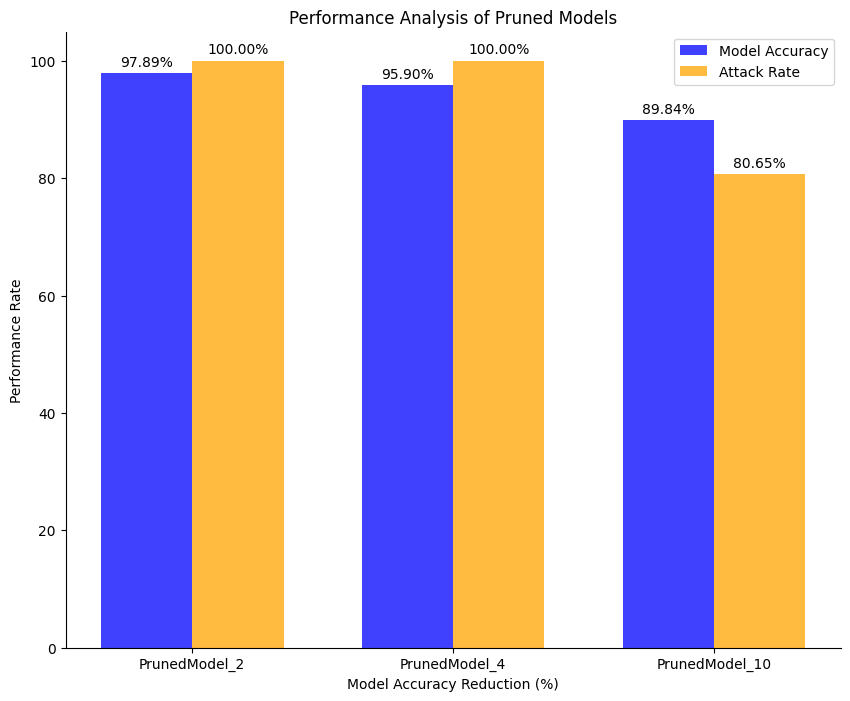

In [19]:
# Setting up plot parameters
bar_opacity = 0.75
width_of_bar = 0.35

# Creating the plot
performance_plot = plt.figure(figsize=(10, 8))
plt.xlabel('Model Accuracy Reduction (%)')
plt.ylabel('Performance Rate')

# Setting the x-axis labels
model_labels = ['PrunedModel_2', 'PrunedModel_4', 'PrunedModel_10']
plt.xticks(np.arange(len(accuracy_scores)) + width_of_bar / 2, model_labels)

# Plotting bars for accuracy and attack rates
accuracy_bars = plt.bar(np.arange(len(accuracy_scores)), accuracy_scores, width_of_bar, alpha=bar_opacity, color='blue', label='Model Accuracy')
attack_rate_bars = plt.bar(np.arange(len(success_rates)) + width_of_bar, success_rates, width_of_bar, alpha=bar_opacity, color='orange', label='Attack Rate')

# Annotating bars with their respective heights
for bar in accuracy_bars + attack_rate_bars:
    bar_height = bar.get_height()
    plt.annotate(f'{bar_height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, bar_height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.legend(loc='upper right')
plt.title('Performance Analysis of Pruned Models')
plt.savefig("PerformanceAnalysisOfPrunedModels.png")
sns.despine()
plt.show()

In [20]:
# Loading test data sets using the custom Dataloader function
test_images, test_labels = Dataloader(clean_test_path)
poisoned_test_images, poisoned_test_labels = Dataloader(poisoned_test_path)

# Displaying the shapes of the loaded test data sets
print(f"Dimensions of Test Images: {test_images.shape}")
print(f"Dimensions of Poisoned Test Images: {poisoned_test_images.shape}")

# Creating instances of the CustomPredictor class with different pruned models
predictor_with_2_prune = CustomPredictor(Model, model_with_2_percent_pruning)
predictor_with_4_prune = CustomPredictor(Model, model_with_4_percent_pruning)
predictor_with_10_prune = CustomPredictor(Model, model_with_10_percent_pruning)

Dimensions of Test Images: (12830, 55, 47, 3)
Dimensions of Poisoned Test Images: (12830, 55, 47, 3)


In [21]:
CustomPredictor_cl_test_2_label_pred = predictor_with_2_prune.predict(test_images)
CustomPredictor_cl_test_2_acc = np.mean(np.equal(CustomPredictor_cl_test_2_label_pred, test_labels))*100
print('Combined 2% accuracy drop model, Clean test data Classification Accuracy:', CustomPredictor_cl_test_2_acc)

CustomPredictor_bd_test_2_label_pred = predictor_with_2_prune.predict(poisoned_test_images)
CustomPredictor_asr_2 = np.mean(np.equal(CustomPredictor_bd_test_2_label_pred, poisoned_test_labels))*100
print('Combined 2% accuracy drop model, Attack Success Rate:', CustomPredictor_asr_2)

CustomPredictor_cl_test_4_label_pred = predictor_with_4_prune.predict(test_images)
CustomPredictor_cl_test_4_acc = np.mean(np.equal(CustomPredictor_cl_test_4_label_pred, test_labels))*100
print('Combined 4% accuracy drop model, Clean test data Classification Accuracy:', CustomPredictor_cl_test_4_acc)

CustomPredictor_bd_test_4_label_pred = predictor_with_4_prune.predict(poisoned_test_images)
CustomPredictor_asr_4 = np.mean(np.equal(CustomPredictor_bd_test_4_label_pred, poisoned_test_labels))*100
print('Combined 4% accuracy drop model, Attack Success Rate:', CustomPredictor_asr_4)

CustomPredictor_cl_test_10_label_pred = predictor_with_10_prune.predict(test_images)
CustomPredictor_cl_test_10_acc = np.mean(np.equal(CustomPredictor_cl_test_10_label_pred, test_labels))*100
print('Combined 10% accuracy drop model, Clean test data Classification Accuracy:', CustomPredictor_cl_test_10_acc)

CustomPredictor_bd_test_10_label_pred = predictor_with_10_prune.predict(poisoned_test_images)
CustomPredictor_asr_10 = np.mean(np.equal(CustomPredictor_bd_test_10_label_pred, poisoned_test_labels))*100
print('Combined 10% accuracy drop model, Attack Success Rate:', CustomPredictor_asr_10)

Combined 2% accuracy drop model, Clean test data Classification Accuracy: 97.74746687451285
Combined 2% accuracy drop model, Attack Success Rate: 100.0
Combined 4% accuracy drop model, Clean test data Classification Accuracy: 95.74434918160561
Combined 4% accuracy drop model, Attack Success Rate: 100.0
Combined 10% accuracy drop model, Clean test data Classification Accuracy: 89.68043647700702
Combined 10% accuracy drop model, Attack Success Rate: 80.6469212782541


In [22]:
# Compiling accuracy and attack rate data into a DataFrame
CustomPredictor_accuracy_scores = [CustomPredictor_cl_test_2_acc, CustomPredictor_cl_test_4_acc, CustomPredictor_cl_test_10_acc]
CustomPredictor_success_rates = [CustomPredictor_asr_2, CustomPredictor_asr_4, CustomPredictor_asr_10]
performance_summary = {
    "Custom Predictor Classification Accuracy (%)": CustomPredictor_accuracy_scores,
    "Custom Predictor Attack Success Rate (%)": CustomPredictor_success_rates,
    "Custom Predictor Model Variant": ["CustomPredictor_2", "CustomPredictor_4", "CustomPredictor_10"]
}

# Creating and formatting the DataFrame
performance_df = pd.DataFrame(performance_summary)
performance_df.set_index('Custom Predictor Model Variant')

,Custom Predictor Classification Accuracy (%),Custom Predictor Attack Success Rate (%)
Custom Predictor Model Variant,,
CustomPredictor_2,97.747467,100.000000
CustomPredictor_4,95.744349,100.000000
CustomPredictor_10,89.680436,80.646921


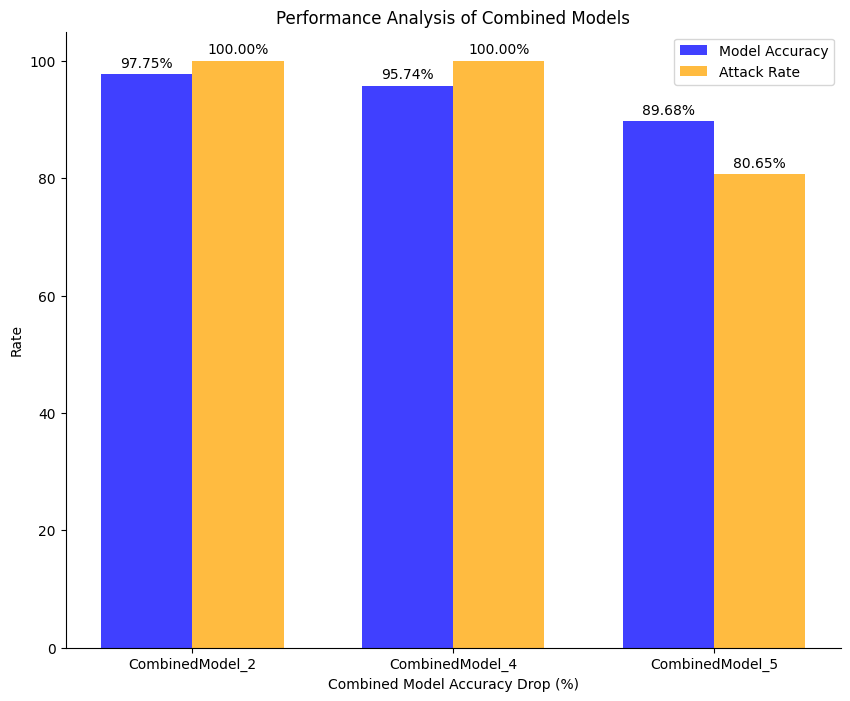

In [23]:
# Setting up plot parameters
bar_opacity = 0.75
width_of_bar = 0.35

# Creating the plot
performance_plot = plt.figure(figsize=(10, 8))
plt.xlabel('Combined Model Accuracy Drop (%)')
plt.ylabel('Rate')

# Setting the x-axis labels
model_labels = ['CombinedModel_2', 'CombinedModel_4', 'CombinedModel_5']
plt.xticks(np.arange(len(CustomPredictor_accuracy_scores)) + width_of_bar / 2, model_labels)

# Plotting bars for accuracy and attack rates
accuracy_bars = plt.bar(np.arange(len(CustomPredictor_accuracy_scores)), CustomPredictor_accuracy_scores, width_of_bar, alpha=bar_opacity, color='blue', label='Model Accuracy')
attack_rate_bars = plt.bar(np.arange(len(CustomPredictor_success_rates)) + width_of_bar, CustomPredictor_success_rates, width_of_bar, alpha=bar_opacity, color='orange', label='Attack Rate')

# Annotating bars with their respective heights
for bar in accuracy_bars + attack_rate_bars:
    bar_height = bar.get_height()
    plt.annotate(f'{bar_height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, bar_height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.legend(loc='upper right')
plt.title('Performance Analysis of Combined Models')
plt.savefig("PerformanceAnalysisOfCombinedModels.png")
sns.despine()
plt.show()